# Linear Regression

In this jupyter notebook you will find the implementation of the linear regression algorithm using the sklearn library. It will help to test this algorithm and to complete [forecasting.md](https://github.com/Hurence/historian/blob/forecasting/docs/forecasting.md) document.

In [1]:
import time
import sklearn.linear_model as sk
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

#### 1) Load and prepare the dataset

For this step we will use pandas library which allow us to read easily a csv file and then create a dataFrame from this file.

In [2]:
# Load the dataset
# ts_data = pd.read_csv('data/dataHistorian.csv', sep=';')
ts_data = pd.read_csv('data/it-data-4metrics.csv', sep=',')

ts_data.head()

,metric_id,timestamp,value,metric_name,warn,crit,min,max
0,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157723,13.375,cpu_prct_used,85.0,95.0,NaN,NaN
1,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157423,13.500,cpu_prct_used,85.0,95.0,NaN,NaN
2,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157123,13.375,cpu_prct_used,85.0,95.0,NaN,NaN
3,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156823,13.500,cpu_prct_used,85.0,95.0,NaN,NaN
4,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156523,13.750,cpu_prct_used,85.0,95.0,NaN,NaN


Now we have our dataFrame with all the information, but some ones are useless. We want to keep only the useful data to reduce calculations' cost.

In [3]:
# Keep only the useful data

#Delete the useless lines
# val_parasite = 0.0
# indexNames = ts_data[ ts_data['value'] < val_parasite ].index
# ts_data.drop(indexNames , inplace=True)

# Delete the useless columns
ts_data = ts_data.iloc[:,0:4]
ts_data.head()

,metric_id,timestamp,value,metric_name
0,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157723,13.375,cpu_prct_used
1,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157423,13.500,cpu_prct_used
2,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157123,13.375,cpu_prct_used
3,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156823,13.500,cpu_prct_used
4,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156523,13.750,cpu_prct_used


We will now split the data according to the different metric_name and then according the different metric_id.  
For that, we will create a dictionnary where the metric_name are the keys and they have lists of their metric_id.

In [4]:
# Creation of the dictionnary of all the metric_name in association with their metric_id
dic_name = {}
dic_id = {}
for indx in ts_data.index:
    if ts_data['metric_name'][indx] not in dic_name.keys():
        dic_name[ts_data['metric_name'][indx]] = []
    if ts_data['metric_id'][indx] not in dic_name[ts_data['metric_name'][indx]]:
        dic_name[ts_data['metric_name'][indx]].append(ts_data['metric_id'][indx])
        dic_id[ts_data['metric_id'][indx]] = [ts_data['metric_name'][indx]]
keys_name = list(dic_name.keys())
keys_id = list(dic_id.keys())

In [5]:
# Split the data into training/validating sets
for indx in keys_id:
    indexNames = ts_data[ ts_data['metric_id'] == indx ].index
    data = ts_data.iloc[indexNames].sort_values(by='timestamp', ascending=True)
    i_opt = 0
    r2_opt = -9999
    for i in range(1, data.shape[0]-1):
        training_limite = i
        training = data.iloc[:training_limite]
        validating = data.iloc[training_limite:]

        # Split the outcome values from the input dataset
        x_train = training['timestamp'].to_numpy().reshape(-1, 1)
        y_train = training['value']
        x_valid = validating['timestamp'].to_numpy().reshape(-1, 1)
        y_valid = validating['value']

        # Create linear regression object
        regr = sk.LinearRegression()
        # Train the model using the training sets
        regr.fit(x_train, y_train)
        # Make predictions using the testing set
        y_pred = regr.predict(x_valid)
        r2 = r2_score(y_valid, y_pred)*100
        if r2 > r2_opt:
            i_opt, r2_opt = i, r2
    dic_id[indx].append(r2_opt)
    training_limite = i_opt
    training = data.iloc[:training_limite]
    validating = data.iloc[training_limite:]
    x_train = training['timestamp'].to_numpy().reshape(-1, 1)
    y_train = training['value']
    x_valid = validating['timestamp'].to_numpy().reshape(-1, 1)
    y_valid = validating['value']
    dic_id[indx].append([x_train, y_train])
    dic_id[indx].append([x_valid, y_valid])
    # Create linear regression object
    regr = sk.LinearRegression()
    # Train the model using the training sets
    start_train = time.time()
    regr.fit(x_train, y_train)
    end_train = time.time()
    # Make predictions using the testing set
    start_val = time.time()
    y_pred = regr.predict(x_valid)
    end_val = time.time()
    dic_id[indx][3].append(y_pred)
    dic_id[indx].append(end_train-start_train)
    dic_id[indx].append(end_val-start_val)

In [6]:
# Here we have two dictionaries:
# First, we have a link between the metric_name and their metric_id

# {'metric_name_1':[metric_id_1, metric_id_2, ...],
#  'metric_name_2':[metric_id_1, metric_id_2, ...],
#  ...}


# Second, we have all the information according to the metric_id

# {'metric_id_1':[metric_name_x, r2_opt, [x_train, y_train], [x_valid, y_valid, y_pred], training_time, inference_time],
#  'metric_id_2':[metric_name_y, r2_opt, [x_train, y_train], [x_valid, y_valid, y_pred], training_time, inference_time],
#  ...}
# 

The next step is to split our dataFrame in two, one part will be used to train our linear regression and the other will be used to test it and verify the accuracy of its predictions. Then we will split the input data to the outcome values.

#### 2) Creation of the LR model

We will create the model, train it and make a prediction on the validating values to verify its accuracy.
In the same time we will mesure the time of training and the time of inference of the model to compare it with other algorithms.

#### 3) Results

The final steps is to collect the results and check the R² indicator. If the results are not satifying, we have to change the parameters, here the size of the training dataset, to have better results.

In [10]:
# # Plot outputs
# for indx in keys_id:
#     fig, ax = plt.subplots()
#     ax.scatter(dic_id[indx][3][0], dic_id[indx][3][1],  color='black')
#     ax.plot(dic_id[indx][3][0], dic_id[indx][3][2], color='blue', linewidth=3)

#     plt.xticks(())
#     plt.yticks(())

# plt.show()

In [8]:
l = []
for indx_name in keys_name:
    somme = 0
    cptr = 0
    for indx_id in dic_name[indx_name]:
        somme += dic_id[indx_id][1]
        cptr += 1
    l.append(somme/cptr)
    
dic = {'metric_name':keys_name, 'r2_mean':l}
r2 = pd.DataFrame(dic)
r2

,metric_name,r2_mean
0,cpu_prct_used,0.008768
1,messages_unacknowledged,34.391755
2,messages,2.169892
3,cpu_usage,9.495498
4,consumers,33.333333
5,ack,33.322863
6,messages_ready,49.480153
7,memoryConsumed,8.831688
8,cpu,0.633794
9,cpu_ready,10.936860


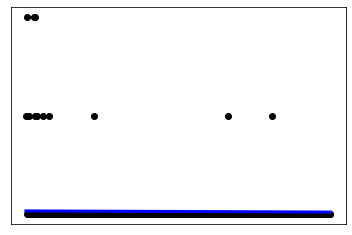

In [9]:
plt.scatter(dic_id[keys_id[29]][3][0], dic_id[keys_id[29]][3][1],  color='black')
plt.plot(dic_id[keys_id[29]][3][0], dic_id[keys_id[29]][3][2], color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()